In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from tqdm import tqdm
import torchtext
from torchtext.data import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from nltk.stem import SnowballStemmer
from tensorflow import keras
from keras.utils import pad_sequences
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import roc_auc_score
import os
import math
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

tqdm.pandas()

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Getting the essays and the labels
# data = pd.read_csv('../prepared_training_set.csv') -> for repo
data = pd.read_csv('../input/prepared-data-llm-competition/prepared_training_set.csv') # for colab
essays = data['essay']
labels = data['LLM_written']

In [3]:
# Creating the tokenizer and stemmer
tokenizer = get_tokenizer('spacy','en_core_web_sm')
stemmer = SnowballStemmer(language='english')

In [4]:
# A function to tokenize and stem each essay
def preprocess_essays(essay:str) -> list:
    prepared_essay = []
    # Preprocessing the essay a bit
    preprocess_essay = essay.replace('\n',"")
    preprocess_essay = essay.replace('\t',"")
    tokenized = tokenizer(essay.replace('\n',""))

    # Getting the lemmas
    prepared_essay = [stemmer.stem(token) for token in tokenized]

    return prepared_essay

In [5]:
# Getting the tokenized essays
tokenized = essays.progress_apply(preprocess_essays)

100%|██████████| 49929/49929 [07:31<00:00, 110.55it/s]


In [6]:
# Getting the vocabulary
vocab = torch.load('../input/models-llm-competition/vocab.pt')

In [7]:
# Creating the training data by inputting the essays through the vocabulary
def put_through_vocab(essay):
    return vocab(essay)

essays_through_vocab = tokenized.progress_apply(put_through_vocab).tolist()

100%|██████████| 49929/49929 [00:02<00:00, 19450.50it/s]


In [8]:
padded_essays = pad_sequences(essays_through_vocab,maxlen=500,padding='post',truncating='post',value=vocab['<pad>'])

In [9]:
# Encodings and Embeddings for Transformer
class TokenEmbedding(nn.Module):
    def __init__(self,vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size,emb_size,padding_idx=vocab['<pad>'])
        self.embed_size = emb_size

    def forward(self,tokens):
        return self.embedding(tokens.long()) * math.sqrt(self.embed_size)

# Positional Encoding
class PositionalEncoding(nn.Module):
    def __init__(self,emb_size:int, dropout:float, maxlen:int = 500):
        super(PositionalEncoding,self).__init__()
        den = torch.exp(-torch.arange(0,emb_size,2)*math.log(10000) / emb_size)
        pos = torch.arange(0,maxlen).reshape(maxlen,1)
        pos_embedding = torch.zeros((maxlen,emb_size))
        pos_embedding[:,0::2] = torch.sin(pos * den)
        pos_embedding[:,1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(0)

        self.dropout = nn.Dropout(dropout)

        # Saving the positional encoding in the model state dict, but making sure PyTorch doesn't "train"
        # these parameters because they don't need to be trained
        self.register_buffer('pos_embedding',pos_embedding)

    def forward(self,token_embedding):
        return self.dropout(token_embedding + self.pos_embedding)

In [10]:
# Transformer Model
class Model(nn.Module):
    def __init__(self,d_model:int,nheads:int,dim_feedforward:int,dropout:float,num_layers:int):
        super().__init__()
        
        self.encoder_layer = nn.TransformerEncoderLayer(d_model,nheads,dim_feedforward,dropout,batch_first=True)
        self.transformer = nn.TransformerEncoder(self.encoder_layer,num_layers)
        self.fc1 = nn.Linear(d_model,1)
    
    # Forward Function
    def forward(self,X,src_key_padding_mask):
        output = self.transformer(X,src_key_padding_mask=src_key_padding_mask)
        output = torch.mean(output,dim=1)
        return nn.functional.sigmoid(self.fc1(output))        

In [11]:
# Creating a mask to make sure the padding indicies are masked
def create_padding_mask(X):
    return (X == vocab['<pad>'])

In [12]:
# Putting the data into a data loader for training
padded_essays_tensor = torch.from_numpy(padded_essays)
labels_tensor = torch.from_numpy(labels.values)

training_data = TensorDataset(padded_essays_tensor,labels_tensor)
training_dataloader = DataLoader(training_data,batch_size=128,shuffle=False)

In [13]:
# Getting GPU
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [14]:
# Setting up the training
embedding = TokenEmbedding(vocab.__len__(),512)
positional_encoding = PositionalEncoding(512,dropout=0.1,maxlen=500)
model = Model(d_model=512,nheads=8,dim_feedforward=2048,dropout=0.1,num_layers=2)
optimizer = torch.optim.Adam(model.parameters(),0.00001)
loss_function = nn.BCELoss()
EPOCHS = 30
history = []
model.to(device)
embedding.to(device)
positional_encoding.to(device)
model

Model(
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
    )
    (linear1): Linear(in_features=512, out_features=2048, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=2048, out_features=512, bias=True)
    (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): 

In [15]:
# Iterating and training
model.train()
for epoch in range(EPOCHS):
    epoch_loss = 0
    print(f'Starting EPOCH {epoch}...')
    for X,y in tqdm(training_dataloader):
        # Model predictions
        X = X.to(device)
        y = y.to(device)
        
        # Getting Embeddings
        embed_input = embedding(X)
        model_input = positional_encoding(embed_input)
        pred = model(model_input,src_key_padding_mask=create_padding_mask(X))

        # Loss function
        loss = loss_function(pred,y.float().view(-1,1))

        # Calculating the gradients
        loss.backward()

        # Taking a step with the optimizer
        optimizer.step()

        # Zeroing out optimizer
        optimizer.zero_grad()

        # Adding the loss to the epoch loss
        epoch_loss += loss.item()

    # Adding the loss to the history
    print(f'EPOCH {epoch} LOSS: {epoch_loss / len(training_data)}')
    print()
    history.append(epoch_loss / len(training_data))

Starting EPOCH 0...


100%|██████████| 391/391 [06:44<00:00,  1.03s/it]


EPOCH 0 LOSS: 0.00413878802660188

Starting EPOCH 1...


100%|██████████| 391/391 [06:51<00:00,  1.05s/it]


EPOCH 1 LOSS: 0.0034685801738459886

Starting EPOCH 2...


100%|██████████| 391/391 [06:50<00:00,  1.05s/it]


EPOCH 2 LOSS: 0.0027074801550300326

Starting EPOCH 3...


100%|██████████| 391/391 [06:50<00:00,  1.05s/it]


EPOCH 3 LOSS: 0.002042622381771322

Starting EPOCH 4...


100%|██████████| 391/391 [06:50<00:00,  1.05s/it]


EPOCH 4 LOSS: 0.0015714069667444193

Starting EPOCH 5...


100%|██████████| 391/391 [06:51<00:00,  1.05s/it]


EPOCH 5 LOSS: 0.0013084037532678232

Starting EPOCH 6...


100%|██████████| 391/391 [06:50<00:00,  1.05s/it]


EPOCH 6 LOSS: 0.0011441351108122768

Starting EPOCH 7...


100%|██████████| 391/391 [06:50<00:00,  1.05s/it]


EPOCH 7 LOSS: 0.00100381478878168

Starting EPOCH 8...


100%|██████████| 391/391 [06:50<00:00,  1.05s/it]


EPOCH 8 LOSS: 0.0008944882153048124

Starting EPOCH 9...


100%|██████████| 391/391 [06:50<00:00,  1.05s/it]


EPOCH 9 LOSS: 0.0008045261391066855

Starting EPOCH 10...


100%|██████████| 391/391 [06:50<00:00,  1.05s/it]


EPOCH 10 LOSS: 0.0007276359249666799

Starting EPOCH 11...


100%|██████████| 391/391 [06:50<00:00,  1.05s/it]


EPOCH 11 LOSS: 0.0006681639864150027

Starting EPOCH 12...


100%|██████████| 391/391 [06:50<00:00,  1.05s/it]


EPOCH 12 LOSS: 0.0006081193620184543

Starting EPOCH 13...


100%|██████████| 391/391 [06:51<00:00,  1.05s/it]


EPOCH 13 LOSS: 0.0005564446462031028

Starting EPOCH 14...


100%|██████████| 391/391 [06:51<00:00,  1.05s/it]


EPOCH 14 LOSS: 0.0005188059472189777

Starting EPOCH 15...


100%|██████████| 391/391 [06:50<00:00,  1.05s/it]


EPOCH 15 LOSS: 0.00048751710022273715

Starting EPOCH 16...


100%|██████████| 391/391 [06:50<00:00,  1.05s/it]


EPOCH 16 LOSS: 0.00045497265825260715

Starting EPOCH 17...


100%|██████████| 391/391 [06:50<00:00,  1.05s/it]


EPOCH 17 LOSS: 0.00042802411205856625

Starting EPOCH 18...


100%|██████████| 391/391 [06:51<00:00,  1.05s/it]


EPOCH 18 LOSS: 0.0003914708268828797

Starting EPOCH 19...


100%|██████████| 391/391 [06:51<00:00,  1.05s/it]


EPOCH 19 LOSS: 0.0003680815251407546

Starting EPOCH 20...


100%|██████████| 391/391 [06:51<00:00,  1.05s/it]


EPOCH 20 LOSS: 0.0003563121902150751

Starting EPOCH 21...


100%|██████████| 391/391 [06:50<00:00,  1.05s/it]


EPOCH 21 LOSS: 0.00033102852053498667

Starting EPOCH 22...


100%|██████████| 391/391 [06:51<00:00,  1.05s/it]


EPOCH 22 LOSS: 0.0003118840446423154

Starting EPOCH 23...


100%|██████████| 391/391 [06:50<00:00,  1.05s/it]


EPOCH 23 LOSS: 0.00029967701776765365

Starting EPOCH 24...


100%|██████████| 391/391 [06:50<00:00,  1.05s/it]


EPOCH 24 LOSS: 0.00029014629493281

Starting EPOCH 25...


100%|██████████| 391/391 [06:50<00:00,  1.05s/it]


EPOCH 25 LOSS: 0.00026457907145028604

Starting EPOCH 26...


100%|██████████| 391/391 [06:50<00:00,  1.05s/it]


EPOCH 26 LOSS: 0.0002625155348890047

Starting EPOCH 27...


100%|██████████| 391/391 [06:50<00:00,  1.05s/it]


EPOCH 27 LOSS: 0.0002449154095951903

Starting EPOCH 28...


100%|██████████| 391/391 [06:51<00:00,  1.05s/it]


EPOCH 28 LOSS: 0.00024378430133709564

Starting EPOCH 29...


100%|██████████| 391/391 [06:50<00:00,  1.05s/it]

EPOCH 29 LOSS: 0.00022667290453382165



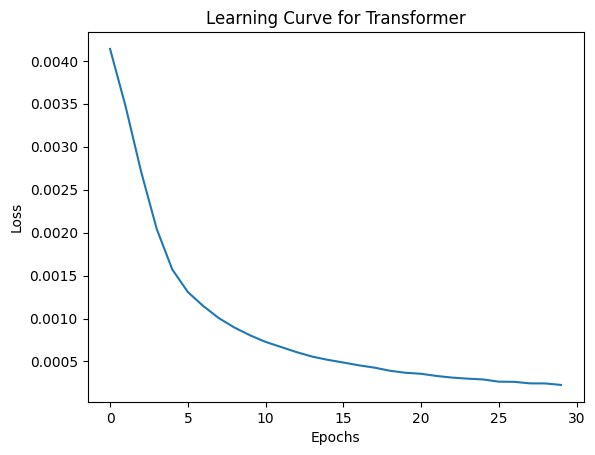

In [16]:
# Plotting the learning curve
plt.title('Learning Curve for Transformer')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(history)
plt.show()

In [17]:
# Performing inference
predictions = None
targets = None
model.eval() # Setting model in eval mode
for X,y in tqdm(training_dataloader):
    X = X.to(device)
    
    embed_input = embedding(X)
    model_input = positional_encoding(embed_input)

    if predictions is None:
        predictions = model(model_input,src_key_padding_mask=create_padding_mask(X)).cpu().detach().numpy()
    else:
        batch_pred = model(model_input,src_key_padding_mask=create_padding_mask(X)).cpu().detach().numpy()
        predictions = np.append(predictions,batch_pred,axis=0)

    # Getting the targets
    if targets is None:
        targets = y.numpy()
    else:
        targets = np.append(targets,y.numpy(),axis=0)

predictions

100%|██████████| 391/391 [02:20<00:00,  2.78it/s]


array([[9.7285402e-01],
       [9.9963844e-01],
       [5.8941817e-01],
       ...,
       [8.3276280e-04],
       [2.4284958e-04],
       [1.9898970e-04]], dtype=float32)

In [18]:
# Checking ROC AUC Score
print('ROC AUC on Training Set:')
print(roc_auc_score(targets,predictions))

ROC AUC on Training Set:
0.9990676363088332


In [19]:
# Saving the model and embedding
torch.save(embedding.state_dict(),'embedding_30_epochs.pt')
torch.save(positional_encoding.state_dict(),'positional_encoding_30_epochs.pt')
torch.save(model.state_dict(),'transformers_30_epochs.pt')